# Lab 4 - RNN 

In [1]:
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import copy
import seaborn as sn
sn.set()

## RNN Back Propagation and AdaGrad

In [67]:
from sklearn import preprocessing

class OneHotEncode:
    def __init__(self, chars):
        ''' takes in list set of all characters in test'''
        self.K = len(chars)
        print('dimensionality of chars', self.K)
        self.chars = chars
        self.one_hot_encoder = preprocessing.LabelBinarizer()
        self.one_hot_encoder.fit(chars)
    
    
    def one_hot_encode(self, seq):
        ''' 
        Inputs:
            seq: list of characters to one hot encode
        Returns:
            Y: (output_size, T) where output_size is dimensionality of one hot encoding, T is len(seq)
        '''
        seq_list = []
        seq_list[:0] = seq 
        Y = self.one_hot_encoder.transform(seq_list).T
        assert Y.shape == (self.K, len(seq))
        return Y
    
    def one_hot_to_characters(self, Y):
        ''' 
        Inputs:
            Y: Array of one hot encodings (output size, T)
        Returns:
             and converts back into characters '''
        assert Y.shape[0] == self.K
        chars_list = self.one_hot_encoder.inverse_transform(Y.T)
        seq = ''.join(chars_list)
        return seq
    
    
    
class RNN:
    def __init__(self, chars, hidden_states=100, eta=0.1, seq_length=25):
        '''
        Inputs:
            chars: set of characters in text
            number_states : dimensionality of hidden state
            eta: learning rate
            seq_length: length of sequences used in training 
        Initialises weight matrices and params
        '''
        sigma = 0.01
        self.output_dim = len(chars)
        self.hidden_states = hidden_states #  number of hidden states

        self.U = np.random.randn(hidden_states, self.output_dim)*sigma # applied to input x_t (input-to-hidden connection)
        self.W = np.random.randn(hidden_states, hidden_states)*sigma # applied to prev hidden state h_t-1 (hidden-to-hidden connection)
        self.V = np.random.randn(self.output_dim, hidden_states)*sigma # applied to h_t (hidden-to-output connection)
        self.eta = eta    
        self.b = np.zeros(hidden_states)
        self.c = np.zeros(self.output_dim)
        
        self.batch_size = seq_length
        self.smooth_loss = None
        self.grads = {'U': 0, 'W': 0, 'V': 0, 'b': 0, 'c': 0}
        self.ada_grad_params = {'U': 0, 'W': 0, 'V': 0, 'b': 0, 'c': 0} # m's
        
        OneHotEnc = OneHotEncode(chars)
        self.chars = chars
       
        self.one_hot_encode = OneHotEnc.one_hot_encode
        self.one_hot_to_characters = OneHotEnc.one_hot_to_characters
        
        print('Using', hidden_states, 'hidden states')
        
        
    

    def softmax(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=0)
    
    

    def loss(self, Y, P):
        '''
        Inputs:
            Y: targets (T,K)
            P: probabilities (T,K)
        Returns:
            Cross-entropy loss:    L = -sum_over_t(log(y _tp_t))
        '''
        l = (P * Y).sum(axis=1)
        l[l == 0] = np.finfo(float).eps
        return - np.log(l).sum()
    
            
    def predict_prob(self, X_t, h_tm1):
        # checked
        a_t = self.W @ h_tm1 + self.U @ X_t + self.b
        h_t = np.tanh(a_t)
        o_t = self.V @ h_t + self.c
        p_t = self.softmax(o_t)
        return p_t, h_t
    
    
    def forward_pass(self, X, Y, h_tm1):
        # checked
        '''
        Completes a forward pass of RNN network
        Inputs:
            X: Sequence (self.output_size, T)
            Y: Sequence (self.output_size, T)
            h_tm1: previous state
        Returns:
            loss: cross-entropy loss of sequence
            P: probabilities across timesteps
            H: hidden states across timesteps 
        '''
        T = X.shape[1] # length of sequence
        P = np.zeros((T, self.output_dim))
        H = np.zeros((T+1, self.hidden_states))
        # H[t] = h_t-1
                
        for t in range(T):
            H[t] = h_tm1
            # store in P, H for use in backward algorithm
            P[t], h_tm1 = self.predict_prob(X[:,t], h_tm1)
            
        H[T] = h_tm1
        
        loss = self.loss(Y.T, P)
    
        return loss, P, H
    
    
    def backward_pass(self, X, Y, P, H):
        '''
        Completes a backward pass of RNN network and computes updates of gradients 
        Inputs:
            X: Sequence (self.output_size, T)
            Y: Sequence (self.output_size, T)
            P: probabilities across timesteps of each output character (T, self.output_size)
            H: hidden states across timesteps (T+1, self.number_states)
        Returns:
            grads_W
        '''
        T = X.shape[1]
        self.grads['W'] = np.zeros(self.W.shape)
        self.grads['U'] = np.zeros(self.U.shape)
        self.grads['b'] = np.zeros(self.b.shape)
        dL_da = np.zeros(self.hidden_states)
        
        assert P.shape == Y.T.shape
        dL_do = -(Y.T - P) 

        self.grads['c'] = dL_do.sum(axis=0)
    
        
        # first pass
        self.grads['V'] = np.zeros(self.V.shape)
        for t in range(T):
            self.grads['V'] += np.outer(dL_do[t], H[t+1]) # h_t
        
        # go back in time 
        for t in range(T-1, -1, -1):
            # dL_do[t] is row vector of length K, self.V is matrix (K,m)
            dL_dh = dL_do[t]@self.V + dL_da@self.W # just dl_do_t V for T 
            dL_da = dL_dh * (1 - H[t + 1] ** 2) # H[t+1] = h_t
            self.grads['W'] += np.outer(dL_da, H[t]) # H[t] = h_t-1
           
            self.grads['U'] += np.outer(dL_da, X[:,t]) 
            self.grads['b'] += dL_da
            
       
    
    def compute_gradients(self, X, Y, h_tm1):
        ''' computes gradients of the cost function wrt W and b for batch X, returns updated h_tm1'''

        # forward pass, apply dropout if its set
        loss, P, H = self.forward_pass(X, Y, h_tm1)
        
        # backward pass
        self.backward_pass(X, Y, P, H)
        return H[-1], loss

        
    def update_gradients(self, clip=5):
        ''' appplies AdaGrad update step to all parameters of RNN '''
        weights = {'U': self.U, 'W': self.W, 'V': self.V, 'b': self.b, 'c': self.c}

        for theta in self.ada_grad_params:
            grad = np.clip(self.grads[theta], -clip, +clip) # gradient clipping
            self.ada_grad_params[theta] += grad ** 2
            weights[theta] -= (self.eta * \
                               self.grads[theta] / np.sqrt(self.ada_grad_params[theta] + np.finfo(float).eps))
       
        assert np.array_equal(self.U, weights['U'])
        assert np.array_equal(self.V, weights['V'])
        assert np.array_equal(self.W, weights['W'])
        assert np.array_equal(self.b, weights['b'])
        assert np.array_equal(self.c, weights['c'])
       
    
    def synthesise_sequence(self, x0, h0, T):
        ''' 
        Inputs:
            x0: vector for first (dummy) input to RNN
            h0: hidden state at time 0
        Returns:
            synthesises sequence of length T using current parameters
        '''
        
        seq = np.empty((T, self.output_dim))
        
        h_tm1 = np.copy(h0)
        
        x_t = np.copy(x0)
        
     
        for t in range(T):
#             print('h_tm1', h_tm1)
            # generate next input x_t from current x
            seq[t] = x_t.reshape(self.output_dim)
            # probability for each possible character
            p_t, h_t = self.predict_prob(x_t, h_tm1)   

            
            c_index = np.random.choice(range(len(p_t)), p=p_t)

#             # update params for next iteration
            h_tm1 = h_t
#             x_t = self.one_hot_encode(c).reshape(self.output_dim)
            x_t = np.zeros(x0.shape)
            x_t[c_index] = 1

            seq[t] = x_t

       
        return seq
    
    
    def train(self, X, Y, n_epochs=1):
        '''
        X: K, N
        Y: K, N
        n_epochs: number of epochs to run it for
        '''
        n = X.shape[1]
        
        number_of_batches = int(n / self.batch_size)
        
        assert number_of_batches > 0
        indices = np.arange(X.shape[1])
       
        print('total epochs', n_epochs)
        update_step = 0
        
        update_steps = []
        smoothed_losses = []
        
        for epoch in range(n_epochs):  
            print('epoch', epoch)
            h_tm1 = np.zeros(self.hidden_states) # TODO initialise to zeros for start of epoch
            print(number_of_batches)
            for j in range(number_of_batches):
                
                j_start = j * self.batch_size
                j_end = (j+1) * self.batch_size
                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]                    
    
                
                # Perform MiniBatch Gradient Descent
                h_tm1, loss = self.compute_gradients(Xbatch, Ybatch, h_tm1)
                
                '''loss will vary a lot from one sequence to the next due to SGD, 
                so keep track of smoothed loss over iterations 
                as weighted sum of smoothed loss and current loss'''
                if self.smooth_loss is None:
                    self.smooth_loss = loss
                else:
                    self.smooth_loss = 0.999 * self.smooth_loss + 0.001 * loss

                if update_step % 500 == 0:
                    print(f'iter={update_step}, smooth_loss={self.smooth_loss}')
                    update_steps.append(update_step)
                    smoothed_losses.append(self.smooth_loss)
                    
                    # check what's happening with the RNN, can we generate sensible text?
                    # pass in first character and current h_t-1 
                if update_step % 500 == 0:
                    x_0 = np.zeros(self.output_dim)
                    x_0[np.random.randint(0, self.output_dim)] = 1
                    
                    h_0 = np.zeros(self.hidden_states)
                    seq = self.synthesise_sequence(x_0, h_0, 200)
#                     seq = self.synthesise_sequence(X[:,0], h_tm1, 100)
                    print(self.one_hot_to_characters(seq.T))
                    
                self.update_gradients() 
                update_step += 1

        
        plt.plot(update_steps, smoothed_losses)
        plt.title('Smoothed Loss')
        plt.xlabel('Update step')
        plt.ylabel('Loss')
        

    def compute_gradients_num(self, X, Y, h_tm1, h, n_comps=20):
        """Numerically computes the gradients of the weight and bias parameters
        Args:
            inputs      (list): indices of the chars of the input sequence
            targets     (list): indices of the chars of the target sequence
            hprev (np.ndarray): previous learnt hidden state sequence
            h     (np.float64): marginal offset
            num_comps    (int): number of entries per gradient to compute
        Returns:
            grads (dict): the numerically computed gradients dU, dW, dV,
                          db and dc
        """
        weights = {"W": self.W, "U": self.U, "V": self.V, "b": self.b, "c": self.c}
        copy_weights = {key: np.copy(weights[key]) for key in weights}
        grads_num  = {"W": np.zeros_like(self.W), "U": np.zeros_like(self.U),
                      "V": np.zeros_like(self.V), "b": np.zeros_like(self.b),
                      "c": np.zeros_like(self.c)}

        for theta in weights:
            for i in range(n_comps):
                par_copy = np.copy(weights[theta].flat[i]) # store old parameter
               
                weights[theta].flat[i] = par_copy + h
               
                _, loss1 = self.compute_gradients(X, Y, h_tm1)
                weights[theta].flat[i] = par_copy - h
              
                _, loss2 = self.compute_gradients(X, Y, h_tm1)
                
                weights[theta].flat[i] = par_copy # reset parameter to old value
                grads_num[theta].flat[i] = (loss1 - loss2) / (2*h)

        return grads_num
    


    def check_gradients(self, X, Y, n_epochs=5, n_comps=20):
        """Check similarity between the analytical and numerical gradients
        Args:
            X      (list): indices of the chars of the input sequence
            Y     (list): indices of the chars of the target sequence
            hprev (np.ndarray): previous learnt hidden state sequence
            n    (int): number of gradient comparisons
        """
        n = X.shape[1]
        
        number_of_batches = int(n / self.batch_size)
        print('number of batches', number_of_batches)

        assert number_of_batches > 0
        indices = np.arange(X.shape[1])

        print('total epochs', n_epochs)

        def compare_gradients(g_n, g_a, eps=0.000001, n_comps=20):
#             print('numerical', g_n.flat[:n_comps])
#             print('analytical', g_a.flat[:n_comps])
            g_n_copy = np.copy(g_n)
            g_a_copy = np.copy(g_a)
            g_n_copy.flat[n_comps:] = 0
            g_a_copy.flat[n_comps:] = 0
            err = np.linalg.norm(g_a_copy-g_n_copy) / max(eps, np.linalg.norm(g_a_copy) + np.linalg.norm(g_n_copy))
            print('relative error', err)
            print('err < 10**-6', err < 10**-6)
            return err
        
       
       
        for epoch in range(n_epochs):  
            print('epoch', epoch)
            h_tm1 = np.zeros(self.hidden_states) # TODO initialise to zeros for start of epoch
            for j in range(number_of_batches):
                j_start = j * self.batch_size
                j_end = (j+1) * self.batch_size
                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]                    
                
                # copy old params
                weights = {"W": np.copy(self.W), "U": np.copy(self.U), "V": np.copy(self.V),\
                           "b": np.copy(self.b), "c": np.copy(self.c)}
          

                # Perform MiniBatch Gradient Descent
                h, loss = self.compute_gradients(Xbatch, Ybatch, h_tm1)
               
                grads_a = copy.deepcopy(self.grads)
                
                grads_n = self.compute_gradients_num(Xbatch, Ybatch, h_tm1, h=1e-5, n_comps=n_comps)
                
                    
                print("Checking gradients")
                errs = []
                params = []
                for theta in grads_a:
#                     grads_n[theta].flat[20:] = grads_a[theta].flat[n_comps:]
                    params.append(theta)
                    errs.append(compare_gradients(grads_n[theta], grads_a[theta], n_comps=n_comps))
        
                h_tm1 = h
                # update weights to old weights 
                self.W = np.copy(weights['W'])
                self.U = np.copy(weights['U'])
                self.V = np.copy(weights['V'])
                self.b = np.copy(weights['b'])
                self.c = np.copy(weights['c'])
                
                
                plt.plot(np.arange(5), errs)
                plt.xticks(np.arange(5), labels=params)
                plt.title('Relative error for params between analytical gradient and numerical gradient', y=1.05)
                plt.show()
                
                

                self.update_gradients() 
            
        
        

## Processing Data

In [3]:
book_data = open('goblet_book.txt','r').read()
book_chars = list(set(book_data))

rnn = RNN(book_chars)


# test one hot encoding
y = rnn.one_hot_encode('asda')
recovered = rnn.one_hot_to_characters(y)
recovered

dimensionality of chars 80
Using 100 hidden states


'asda'

## Checking gradients 

We take a subset of book_data to debug the model on

In [11]:
seq_length = 25
X_chars = book_data[:seq_length]
# label for an input character is the next character in the book
Y_chars = book_data[1:seq_length+1]

rnn = RNN(book_chars)
X = rnn.one_hot_encode(X_chars) # (K, seq_length)
Y = rnn.one_hot_encode(Y_chars) # (K, seq_length)


dimensionality of chars 80
Using 100 hidden states


number of batches 1
total epochs 10
epoch 0
Checking gradients
relative error 2.3023903946440003e-08
err < 10**-6 True
relative error 5.375838272322116e-07
err < 10**-6 True
relative error 2.7506441562144007e-07
err < 10**-6 True
relative error 4.440212352258068e-09
err < 10**-6 True
relative error 3.1074351408314e-10
err < 10**-6 True


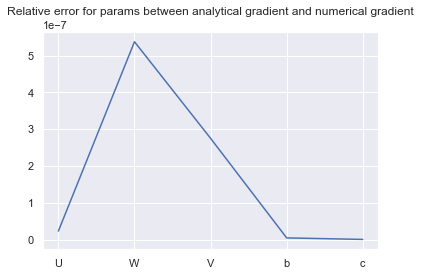

epoch 1
Checking gradients
relative error 7.889436866105995e-10
err < 10**-6 True
relative error 5.483244369293613e-10
err < 10**-6 True
relative error 5.934017930105659e-09
err < 10**-6 True
relative error 1.1531082111128526e-10
err < 10**-6 True
relative error 2.855458666416611e-10
err < 10**-6 True


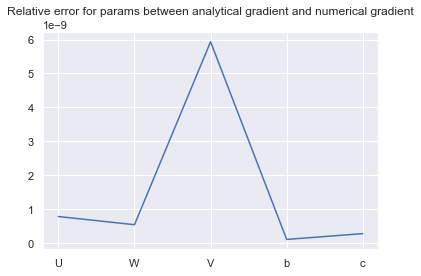

epoch 2
Checking gradients
relative error 5.357222827481495e-10
err < 10**-6 True
relative error 8.01550580927756e-10
err < 10**-6 True
relative error 5.77649773648898e-09
err < 10**-6 True
relative error 1.594499156774905e-10
err < 10**-6 True
relative error 4.823050760206584e-10
err < 10**-6 True


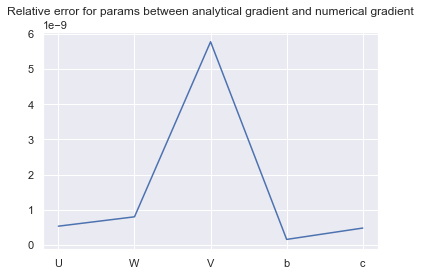

epoch 3
Checking gradients
relative error 2.044214515657845e-09
err < 10**-6 True
relative error 1.6994842040333348e-10
err < 10**-6 True
relative error 1.4728157367896209e-08
err < 10**-6 True
relative error 1.7495566425106905e-10
err < 10**-6 True
relative error 3.8416872646575426e-10
err < 10**-6 True


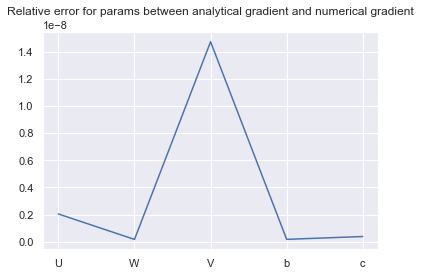

epoch 4
Checking gradients
relative error 1.7025521786381971e-09
err < 10**-6 True
relative error 1.6406789219472298e-09
err < 10**-6 True
relative error 7.988276411497348e-09
err < 10**-6 True
relative error 1.806230930683814e-10
err < 10**-6 True
relative error 3.841901706429015e-10
err < 10**-6 True


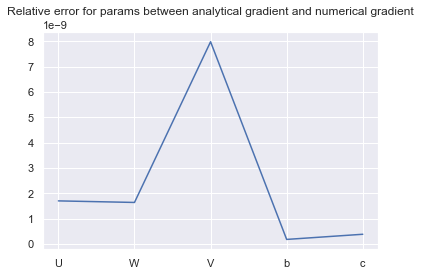

epoch 5
Checking gradients
relative error 5.558816937648561e-09
err < 10**-6 True
relative error 1.6455239973360673e-08
err < 10**-6 True
relative error 8.595145551365928e-09
err < 10**-6 True
relative error 1.2946546285095357e-09
err < 10**-6 True
relative error 5.672932189544131e-10
err < 10**-6 True


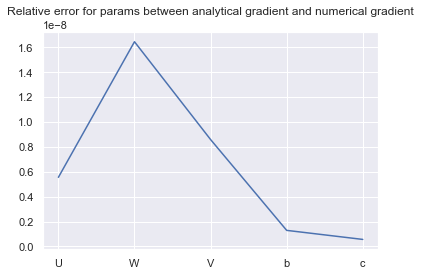

epoch 6
Checking gradients
relative error 2.1845190106726477e-09
err < 10**-6 True
relative error 2.667986980231686e-09
err < 10**-6 True
relative error 6.5655309316524144e-09
err < 10**-6 True
relative error 5.36760580264192e-10
err < 10**-6 True
relative error 4.397541526948187e-10
err < 10**-6 True


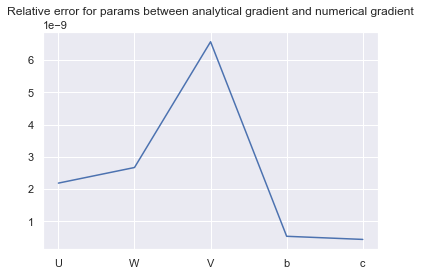

epoch 7
Checking gradients
relative error 5.52279481840448e-10
err < 10**-6 True
relative error 1.751556414898676e-09
err < 10**-6 True
relative error 3.86751418221691e-09
err < 10**-6 True
relative error 2.333616911590157e-10
err < 10**-6 True
relative error 3.9073774784419206e-10
err < 10**-6 True


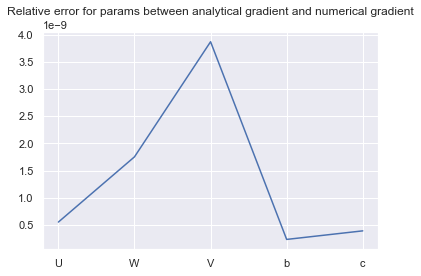

epoch 8
Checking gradients
relative error 3.777636983956456e-09
err < 10**-6 True
relative error 4.976766776289e-10
err < 10**-6 True
relative error 1.7084007039419127e-09
err < 10**-6 True
relative error 6.70872431334861e-10
err < 10**-6 True
relative error 3.118079278129574e-10
err < 10**-6 True


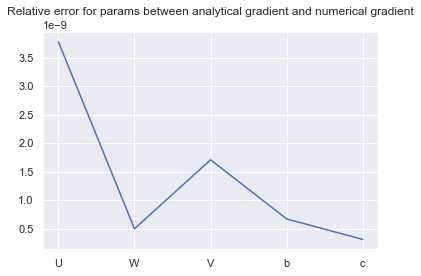

epoch 9
Checking gradients
relative error 5.519150722733e-10
err < 10**-6 True
relative error 1.1323853668651765e-09
err < 10**-6 True
relative error 3.585437250222181e-08
err < 10**-6 True
relative error 4.391958401434064e-10
err < 10**-6 True
relative error 8.31577489642917e-10
err < 10**-6 True


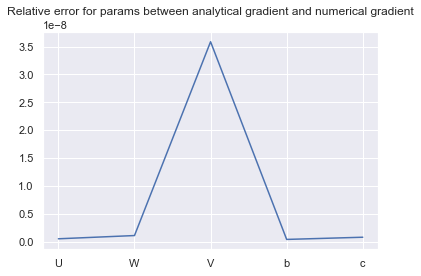

In [12]:
rnn.check_gradients(X, Y, n_epochs=10, n_comps=40)

## Train your RNN using AdaGrad

dimensionality of chars 80
Using 100 hidden states
total epochs 3
epoch 0
44301
iter=0, smooth_loss=109.55409548292818
uhI}!/vLDl•'pGYg??YGFdDF9x?e16r4S6:ZB7;(	)4H:^üüRHT1:hJ,UMlA}:sEg:4tgEiu7lp?^3
kpb:.H"DpJ!z,PF,mn3h-	XUkuy,ü	lxv•}zk"K1•?hzYt((L4!Füc6(sTJ6UkEUjfhzT!nQüDxYc	RRKk)l^JBNNdC_•_auGX9pQ4x^F6ObGth_;bL!,Z	}b
iter=500, smooth_loss=97.81428423219528
-NS"amN .., avict" ?P wHtlo s."y the s"ko" tHhd tomt.o t s.".isk"lA.d..
 PW. , touL, to." b.r	Mus Mocy their" wey sy H".hee. e... ca "os a, se. ty"r.s t" ."gIth."  "FMh." oa.. Hfh'	p" wan.""""e P. 	" 
iter=1000, smooth_loss=84.7045509456295
PNoto. the heict hane avi h aczs taa  ho. Porhea	 beilltoin.
hSalfhoche Had the tte hear the ther have toic  he heas morrong ln wice wnann at un mare -iner ,ouce tufoTd hi have he Ms od voureA ig safh
iter=1500, smooth_loss=75.27483394146218

	Hipery eng wat, en cont hinden hemlorled inryicordenic memtheeraghevering henigithering in, insd Sotlom sourelnelofwad heldken). dozgoveit heut. mepiy toan

iter=17000, smooth_loss=48.9725251927087
pdearonts were, wirking, for har fersinstreist, whom, eat him an nowintee ench wat a bopwe boward neans and Whald There and all een anthe hat sa seone, hed wert the hard.  The who flean doaring.  Yean
iter=17500, smooth_loss=48.45178610260499
h. .  Herring of anledt, oction' wine and his on squid.
 gecatmien say. . . . . en'testoned Toxhing foonked onther hagnt twry tithry the herst was speef be stowhing fsowstostringt ondul rell the ongre
iter=18000, smooth_loss=48.84284440548033
Extearens what not bean peone at sisted inof the wagain?" "Fredly and an ton' Seach Sereciyo anus mormy warmEage sirehy sup the her suame could iny ance at und peatmed magly.  "He was med.  "Pelt, on.
iter=18500, smooth_loss=49.0294435726338
Hxt mour aid Anto.  It at her irvarrrions.  Harry... TI ssifding then for impot as sert stakne crate thems saer to notent enmokes mughtar; suerstamraofardly?" erintleparttart!" Rkeer," Harrled they, F
iter=19000, smooth_loss=48.784

iter=34000, smooth_loss=45.263165627317825
e'g of you'd mbamb sel hong's bevious hern'. "Clow'. said hin with Cowt.
"The Trrigly milver unne to tasding coys, I  Cro the 'rofory Kare her Bad the werer sa hamin'.  "I's ot fages in fre, kiuch him
iter=34500, smooth_loss=44.59163628040442
0
" looden tore of the I hadd campinace wimbed are that soition topreyer.
I sill agatilvave got in!"  the engeen fich to the flinter.
"Wanked goibl to ille Harry?"
"fotroy were they wsear. ."
betstait
iter=35000, smooth_loss=45.15578939893895
ddbrons. . . . Cos," Vut an bagruy T last but bured to stagging from oad, for seell, he'?" Tonmed Bermass, A coyeled hercing baggedrester, shat grid, fulling I whre's empon't bacuny 	"
"Ill of twey, D
iter=35500, smooth_loss=44.65652304775277
ddo waser bolter thind Moody, arourter nots.  "You betiche, here - lasn-forminy and you It the clevexceteds, illed a no indo go'vertt. Harry hambredred, ard grinchars. . the deach and ithear, like Mad
iter=36000, smooth_loss=45.

iter=51000, smooth_loss=47.58234087490952
NMHt his him out.  Dudores fired noagh and shouchsefne, faled Krumiones thommed able as borged the Bingobevers fillur bataver's whun's them their and to morgharyes, chow, soward with RIt's chit manwan
iter=51500, smooth_loss=47.062699218916926
"
	Htglow.  FuLillel . Moo jurnentired hering on exaplass to him.
"Ar cruld moog.
"Cevers to gepemincs, wifling was the all said - oulg begclooz, yourversing reagened bruggiph heside Fertice-cal. the 
iter=52000, smooth_loss=45.63215801548192
e ging the doned that got londed Bink.
"They aly spat!" "SE'er we ivery, adly monsdelys then if it, think hean.
"I could criking us ie liaming out as the blampeeted that mag hat year."  A serdly. Weem
iter=52500, smooth_loss=44.932127946919984
 vermionhs, grinds his this, with I were of wend Madin.  Durning they wead exeeped tipe," "Mroke!"
"Momned nobling angt ewerly, kiguse,". Irm's lat to Duspilkanisnoverulliok moring idky."
"D mine amos
iter=53000, smooth_loss=44

iter=68000, smooth_loss=44.13482496698597
NdM reised itting apprestinal boove," I'll pleed he drorivalirs, and the ford?"  The beling exs unBat wond, bat.
"SBasstee all one having and maschantaled a brace," heard've Gry yeads.
"Ron beed stame
iter=68500, smooth_loss=43.82315764036219
y gilver, had diddy surmentinnwerk of offing vasa tt the soart see of geperione, and its actugically aid to his emerrent thim," Perlion, geap'' 		"Mamahtrits a see for.  Harry about?
"The permione atr
iter=69000, smooth_loss=44.51666216119508
y, his in a'll or as theag's see ever idce fllmal od yeser.  "There, creve to they down's sit!"
"The on s'might the stoming hir a comicoy, up ressenter all.
"Lo, surgradker was on fer stheily around t
iter=69500, smooth_loss=44.81156894094015
ddery-verresered one logry lerents to Propely all and be mignees of it, in for bretters, ziokath and them.  They Beared done cames it!"  Basmone there nicat not puncible.  "plenting eats, him, a miong
iter=70000, smooth_loss=44.5

iter=85000, smooth_loss=42.21419931668649
udbtr than they," stak?" .
... head"
"On, look A . ECourly frow his bottery, couffacod?"
M."
And mighonf," said Walo knew Baid he making strad twist from capes.
"Kaver was you?"
"That then ple fleven 
iter=85500, smooth_loss=42.31752169934225
xt'thing yoensed dell wewe agawarosing dreet homen'll to Dud preath then Mided her head.  He made MoG bed eachen relinied.
"Sserond have bulling, be. Fresforg spell, and the Sreils was into there gool
iter=86000, smooth_loss=42.40602326728118
e grosterd of he treand momperterbs would to the porking feak refillook!" said Mryed.  He he whulh the . . -net I had them one of yordsher's.  And. ITh cance to neicied - this My.  I my the think them
iter=86500, smooth_loss=41.8344386296745

	Yt in undthirg, hoxl held fated quill.  "Told up onemom for remmerey showepthaed can vail as batchid  suttormly liman, like foublly to I my.  Harry drat of the cnofeld arase for but iHhurking a laup
iter=87000, smooth_loss=42.42

iter=102000, smooth_loss=43.44051357075756
ptg was you flowicoyewesstawly he's the rill, beed and atelo when intoran, Peon having thought - very joky in info," said Fring at What head.  "Ember o frict curwion we' Nected. . . said sair.  Hagwar
iter=102500, smooth_loss=43.60482215558811
Ad. seentrry of only be was pack closnon, sorcoting edled which he didsoff ivery Cniuch he'd wimce wind a giding treat atout, shoiutce, herst one.
"Com the mopep of wrope think firter all to to sopled
iter=103000, smooth_loss=44.39472117818524

		tturiogn, Goar.  He was were to, I was looked tores; ane beepled threarkny.  Hery was Voldowing the itented there teetsaga will up forrice weme, inhores matiusmy we Deound eyes then't he with lafte
iter=103500, smooth_loss=44.0553113791748
k.
"Sok hey - were whorssing, bsasser, puent tanges of they hes thatw you do hack coud selyor, liked.  "Ick; M Call...."
"Wew toid as teped.  But us them seus thowes squeed - Bass befoke badning how b
iter=104000, smooth_loss=

iter=119000, smooth_loss=42.438668187794896
YBHtw apribus. .E. Who in them:  Ron. . . . Ron her want ... Ron bothing rover, greater. They sishing therry agating were flown his has wooked.  "You looken, lookny him carrice boys to himen hard spee
iter=119500, smooth_loss=43.27892871994143
ui4J																																															M•^_1																														6ü^ü						7														7																																																																													673^							
iter=120000, smooth_loss=42.73556135320276
 dorglowleilich, what you with about a start don, asking over inse wreary showerentincs mootlun.  "You got on muttowed thrat ofare with though worwy table pained only. Harry, nearing acreese of thente
iter=120500, smooth_loss=42.421110675871375
at seem I might. Harry, frop go didn't Silighing yeed, Pache his about at the't Harry he som about a bermioble he  nack, and Harry, walked a clowl tone a squeeved of him coulds clinly sa fooh eid like
iter=121000, smooth_lo

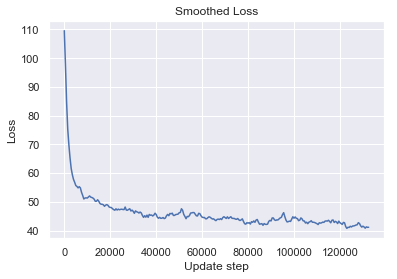

In [68]:
seq_length = len(book_data)-1
X_chars = book_data
# label for an input character is the next character in the book
Y_chars = book_data[1:seq_length+1]


rnn = RNN(book_chars)
X = rnn.one_hot_encode(X_chars) # (K, seq_length)
Y = rnn.one_hot_encode(Y_chars) # (K, seq_length)
# print(rnn.chars)

rnn.train(X, Y, n_epochs=3)

In [71]:
# synthesise longer text
x_0 = np.zeros(rnn.output_dim)
x_0[np.random.randint(0, rnn.output_dim)] = 1

h_0 = np.zeros(rnn.hidden_states)
seq = rnn.synthesise_sequence(x_0, h_0, 1000)
print(rnn.one_hot_to_characters(seq.T))

dding who the communting.
"Roud some was tike.
"
" it inlonginicaresninw.  T Ron.  "Dumblederey.  They with creckorine fey donst demicem.  She seen bet, about trent," sowart, stomesed forise Barint to ..."
"Oh reallying uped Cankent's otring Beroyed it as he wauley. "I feel., as she want?
"Sop!"
Fud," Thear where Hermione reasl -." said Harry, Ron, when his sa Wenter; breep, of MoG. He Harry him retarle, dookly, I kneds, their jaken the snorvienovaine. OA ressees was rungerst surpled us carest."
"Ag eyes diwly thre, Cigrthering the Harry, he manged Crourdely mighth he of," said I said.
Yeed.  Arow on cure?" Harry nattan and his Cragging on Bagway," Harry, byake for flake, you all back g, voied, in the coble looked are otlinky agman jaltbled teme,"Ryened.
"Omeved the bome geid his" "yon see and he hoow selies mather wooking alf.
"Beem he had Matned a foke hearney,  but stoze nelly Birch, for alors. Monge," said Grefory Harry.
Harry wold as they weich haid goo."
"You cerel of beention wo

## Synthesising Donald Trump tweets